In [1]:
from Scripts.essentials import *
import h5py
plt.rcParams.update({'font.size': 30})
plt.rcParams["font.family"] = "Times New Roman"

Available computational components
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4474269204620325865
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5835325440
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16081796394616419696
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 OEM, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [2]:
# Load the data into memory
data_path = "Data/Live_Cells_Sample/"

data = []
data_names = []
for sample in os.listdir(data_path):
    with h5py.File(data_path + sample) as f:
        regions = f["Regions"]
        
        datasets = np.empty((0, 1738))
        for region in list(regions):
            datasets = np.concatenate((datasets, np.nan_to_num(normalize(np.array(regions[region]["Dataset"]).reshape(-1, 1738)))))
            
        data.append(datasets)
        data_names.append(sample)

(8972, 1738)


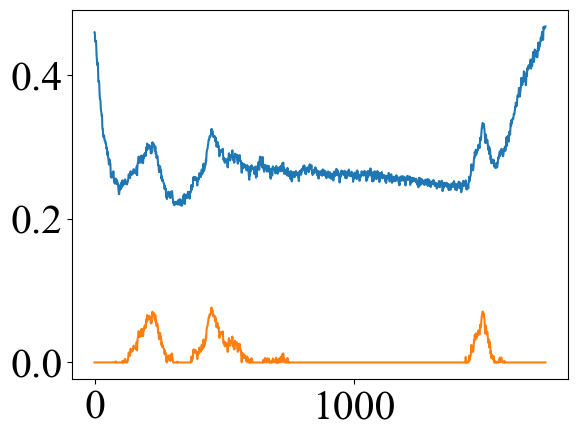

(8784, 1738)


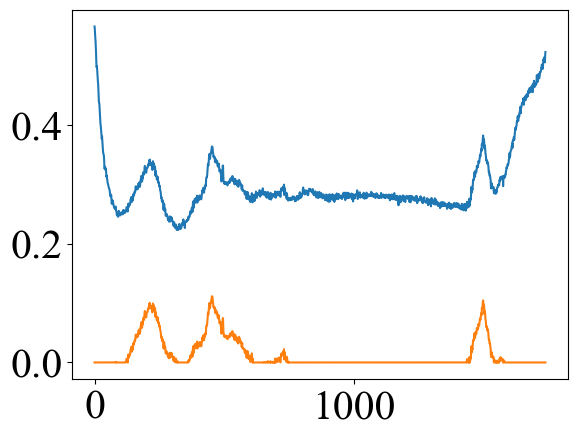

(10530, 1738)


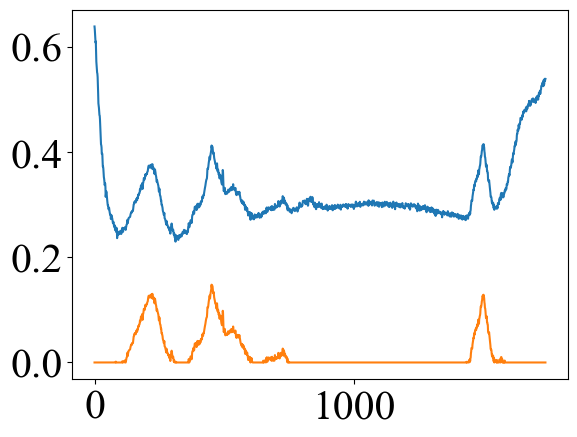

(11230, 1738)


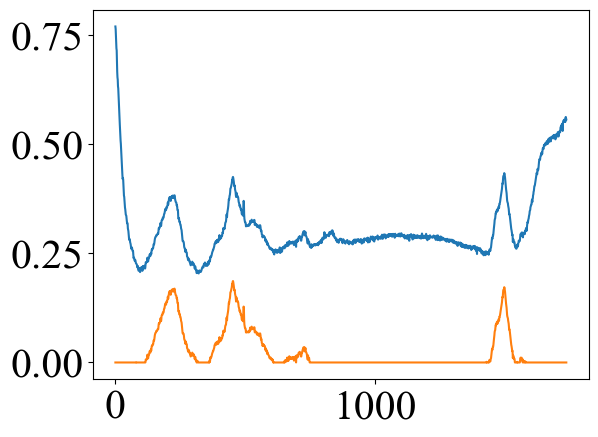

(8372, 1738)


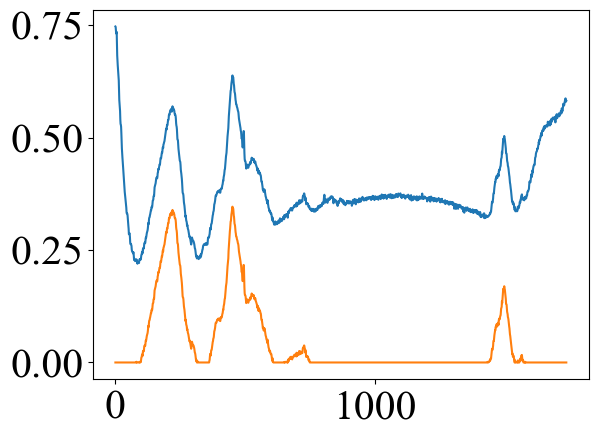

(7710, 1738)


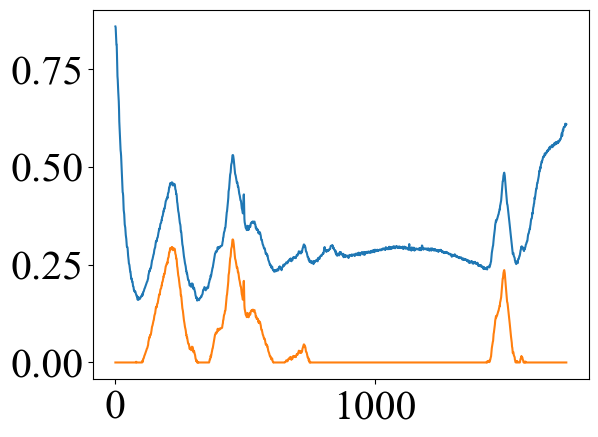

(6490, 1738)


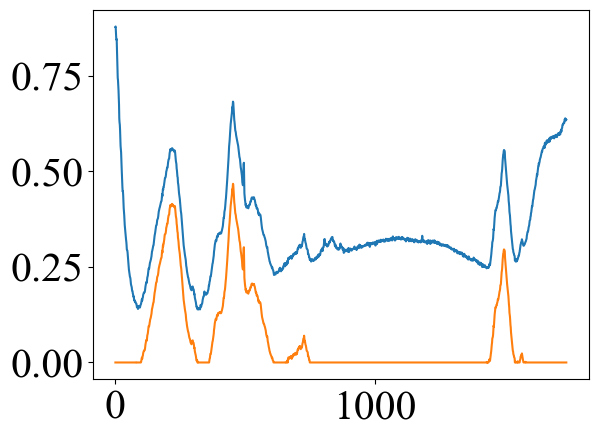

(5468, 1738)


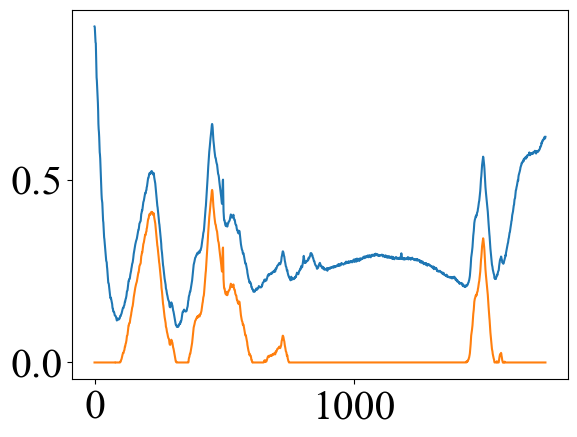

(5724, 1738)


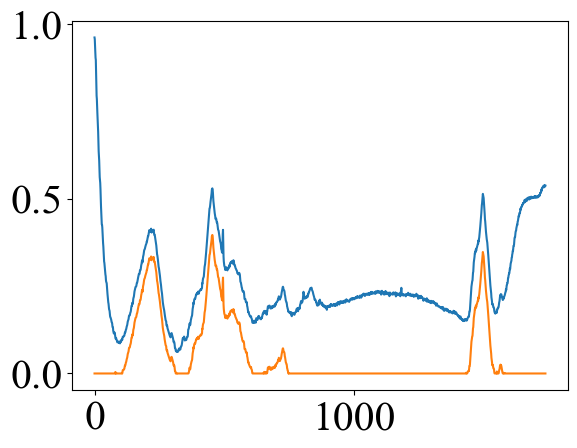

(1500, 1738)


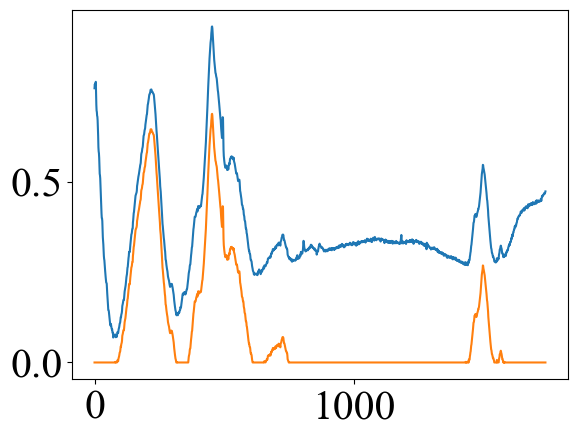

In [3]:
ranges = [[80, 320], [360, 610], [650, 750], [1430, 1550], [1555, 1580]]
targets = []
for i in range(len(data)):
    print(data[i].shape)
    target = np.mean(np.array(np.nan_to_num(data[i])).reshape((-1, 1738)), axis = 0)
    new_target = np.zeros_like(target)
    # Get the peaks
    for r in ranges:
        peak = target[r[0]: r[1] + 1]
    
        
        start = np.median(peak[0:3])
        end = np.median(peak[-3:])
    
        # The baseline at peak location is a linear line between the medians of the left and right ends, estimated by the 10 first and last points
        bl = np.linspace(start, end, r[1] - r[0] + 1, axis = -1)
    
        # Remove the baseline
        new_peak = np.clip(peak - bl, 0, 1)
    
        # Insert the peak
        new_target[r[0]:r[1]+1] = new_peak
    plt.plot(target)
    plt.plot(new_target)
    plt.show()
    
    targets.append(new_target)

In [3]:
ensemble_model = make_ensemble()
ensemble_model.load_weights(filepath= "Models/ensembleModelRes.h5")

standard_model = make_standard()
standard_model.load_weights(filepath = "Models/standardModel.h5")

cascade = tf.keras.models.load_model("Models/unet_three.23-64.96.h5")

In [5]:
ensemble_preds = {}
standard_preds = {}
for d, n in zip(data, data_names):
        
    dn_1 = d.reshape((-1, 1738))
    print(n, dn_1.shape)
        
    denoised_1 = ensemble_model.predict(np.expand_dims(dn_1, -1))[-1]
    denoised_2 = standard_model.predict(np.expand_dims(dn_1, -1))[-1]
    
    ensemble_preds[n] = denoised_1
    standard_preds[n] = denoised_2



cell100x0_0025sec25slit.h5 (8972, 1738)
281/281 [==============================] - 22s 77ms/step
cell100x0_005sec25slit.h5 (8784, 1738)
275/275 [==============================] - 21s 78ms/step
cell100x0_01sec25slit.h5 (10530, 1738)
330/330 [==============================] - 25s 77ms/step
cell100x0_025sec25slit.h5 (11230, 1738)
351/351 [==============================] - 42s 120ms/step
cell100x0_05sec25slit.h5 (8372, 1738)
262/262 [==============================] - 22s 84ms/step
cell100x0_1sec25slit.h5 (7710, 1738)
241/241 [==============================] - 19s 77ms/step
cell100x0_25sec25slit.h5 (6490, 1738)
203/203 [==============================] - 16s 78ms/step
cell100x0_5sec25slit.h5 (5468, 1738)
171/171 [==============================] - 13s 78ms/step
cell100x1sec25slit.h5 (5724, 1738)
179/179 [==============================] - 14s 77ms/step
cell100x2sec25slit.h5 (1500, 1738)
47/47 [==============================] - 4s 77ms/step


In [6]:
casc_preds = {}
for d, n in zip(data, data_names):
    print(n)
        
    dn_1 = d.reshape((-1, 1738)) * 1000
        
        # Model is designed for spectrum length 1024, split the spectrum in half 
    denoised_1 = np.squeeze(cascade.predict(np.expand_dims(dn_1[:, :1024], -1))[-1]/1000)
    denoised_2 = np.squeeze(cascade.predict(np.expand_dims(dn_1[:, -1024 :], -1))[-1]/1000)
        
        #Join the predictions in the middle
    denoised = np.hstack((denoised_1[:, :1738 - 1024], denoised_2))
        
    casc_preds[n] = denoised


cell100x0_0025sec25slit.h5
281/281 [==============================] - 46s 163ms/step
cell100x0_005sec25slit.h5
275/275 [==============================] - 27s 99ms/step
cell100x0_01sec25slit.h5
330/330 [==============================] - 33s 101ms/step
cell100x0_025sec25slit.h5
351/351 [==============================] - 59s 169ms/step
cell100x0_05sec25slit.h5
262/262 [==============================] - 26s 99ms/step
cell100x0_1sec25slit.h5
241/241 [==============================] - 24s 101ms/step
cell100x0_25sec25slit.h5
203/203 [==============================] - 24s 117ms/step
cell100x0_5sec25slit.h5
171/171 [==============================] - 28s 165ms/step
cell100x1sec25slit.h5
179/179 [==============================] - 16s 90ms/step
cell100x2sec25slit.h5
47/47 [==============================] - 5s 101ms/step


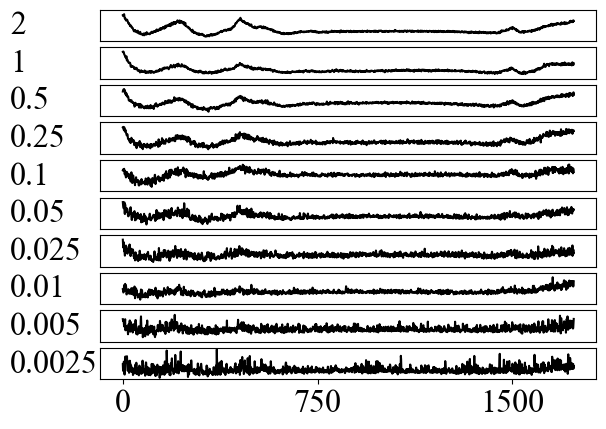

KeyError: 'cell100x2sec25slit.h5_0'

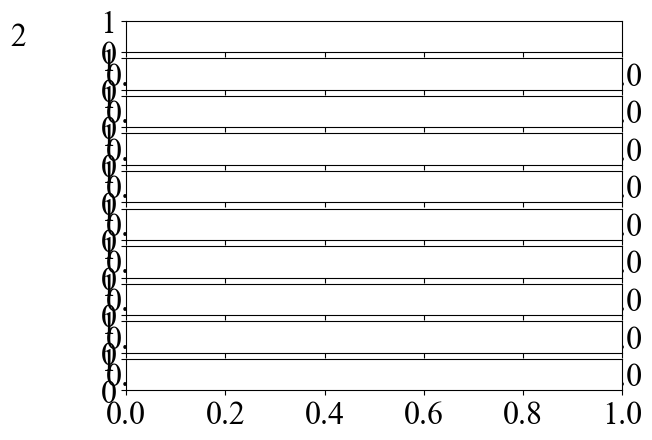

In [7]:
plt.rcParams.update({'font.size': 23})
plt.rcParams["font.family"] = "Times New Roman"
y_labels = []
for y in  data_names:
    txt = y[y.index("x")+1: y.index("s")]
    y_labels.append(txt.replace("_", "."))
    
fig, axs = plt.subplots(len(data_names), sharex=False, sharey=False)
for i in range(len(data)):
    
    axs[i].plot(normalize(data[-(i+1)][0].reshape((-1, 1738)))[0], color = "Black")
    axs[i].set_ylabel(np.flip(y_labels)[i], rotation=0, loc='bottom', labelpad=65)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_ylim(-0.2, 1.2)
plt.autoscale() 
plt.xticks([0, 750, 1500])
plt.savefig("Figures/LiveCellDenoising/Sample.png",
                   bbox_inches='tight', pad_inches=0.75)
plt.show()


names = ["Ensemble", "Standard", "Cascaded"]
for names_ix, preds in enumerate([ensemble_preds, standard_preds, casc_preds]):
    
    fig, axs = plt.subplots(len(data_names), sharex=False, sharey=False)
    for en, n in enumerate(reversed(data_names)):
        axs[en].set_ylabel(np.flip(y_labels)[en], rotation=0, loc='bottom', labelpad=65)
        axs[en].plot(preds[n+"_0"][0], color = "Green")
        axs[en].set_xticks([])
        axs[en].set_yticks([])
        axs[en].set_ylim(-0.2, 1.2)
        
    plt.autoscale() 
    plt.xticks([0, 750, 1500])
    plt.savefig("Figures/LiveCellDenoising/" + names[names_ix] + ".png",
                   bbox_inches='tight', pad_inches=0.75)
    plt.show()
        #    plt.plot()

In [ ]:
names = ["Ensemble", "Standard", "Kazemzadeh et al."]

metrics = []
for data_name, new_target in zip(data_names, targets):
    metrics.append([])
    
    print(data_name)
    names_ix = 0
    for p in [ensemble_preds, standard_preds, casc_preds]:

        ix = new_target > 0.0
        peak_rmse = 1 - np.mean(np.nan_to_num(p[data_name]), axis = 0)[ix]/new_target[ix]
        peak_rmse = np.sqrt(np.mean(np.power(peak_rmse, 2)))
        m = peak_rmse
        
        # RMSE
        #m = np.sqrt(np.mean(np.power(new_target - np.nan_to_num(p[data_name]), 2)))
        maxim = np.max(new_target)
        #m = np.sqrt(np.mean(np.power(new_target/maxim - np.nan_to_num(p[data_name]/maxim), 2)))
        m = np.max(np.abs(new_target/maxim - np.nan_to_num(p[data_name]/maxim)))
        
        print(m)
        metrics[-1].append(m)
        names_ix += 1
    
metrics = np.array(metrics)
exp_times = []
for data_name in data_names:
    t = data_name[len("cell100x"): len("cell100x") + data_name[len("cell100x"):].find("s")]
    t = t.replace("_", ".")
    t = float(t)
    exp_times.append(t)
exp_times = np.array(exp_times)
sorting = np.argsort(exp_times)

exp_times = exp_times[sorting]
metrics = metrics[sorting]

In [ ]:
plt.rcParams.update({'font.size': 23})
plt.rcParams["font.family"] = "Times New Roman"

fig, ax = plt.subplots(figsize = (15, 5))

plt.plot(metrics[:, 2], color = "gray", label = "Kazemzadeh et al.")
plt.scatter(np.arange(len(metrics)), metrics[:, 2], color = "gray")

plt.plot(metrics[:, 1], color = "tan", label = "Standard.")
plt.scatter(np.arange(len(metrics)), metrics[:, 1], color = "tan")

plt.plot(metrics[:, 0], color = "darkorange", label = "Ensemble.")
plt.scatter(np.arange(len(metrics)), metrics[:, 0], color = "darkorange")

plt.xticks(np.arange(len(exp_times)), exp_times, rotation = -60)

plt.legend()
plt.xlabel("Exposure time in seconds")
plt.ylabel("Max Error")

plt.savefig("Figures/LivecellExposureTimeReduction.png",
                   bbox_inches='tight', pad_inches=0.75)
plt.show()

In [ ]:
for t, n in zip(targets, data_names):
    
    maxim = np.max(t)
    
    fig, ax = plt.subplots(1, 3, figsize = (15, 5), sharey = True)
    
    ax[0].plot(t/maxim)
    mean = np.mean(ensemble_preds[n]/maxim, axis = 0)
    std = np.std(ensemble_preds[n]/maxim, axis = 0)
    ax[0].fill_between(np.arange(len(mean)), mean + std, np.clip(mean - std, 0, 1), color = "darkorange", alpha = 0.4)
    ax[0].plot(mean, color = "darkorange")

    
    ax[1].plot(t/maxim)
    mean = np.mean(standard_preds[n]/maxim, axis = 0)
    std = np.std(standard_preds[n]/maxim, axis = 0)
    ax[1].fill_between(np.arange(len(mean)), mean + std, np.clip(mean - std, 0, 1), color = "tan", alpha = 0.4)
    ax[1].plot(mean, color = "tan")

    
    ax[2].plot(t/maxim)
    mean = np.mean(casc_preds[n]/maxim, axis = 0)
    std = np.std(casc_preds[n]/maxim, axis = 0)
    ax[2].fill_between(np.arange(len(mean)), mean + std, np.clip(mean - std, 0, 1), color = "gray", alpha = 0.4)
    ax[2].plot(mean, color = "gray")
    #plt.ylim([-0.05, 1.1])
    plt.show()

[199, 484, 699, 1489, 1567]
cell100x2sec25slit.h5
(100, 1738)


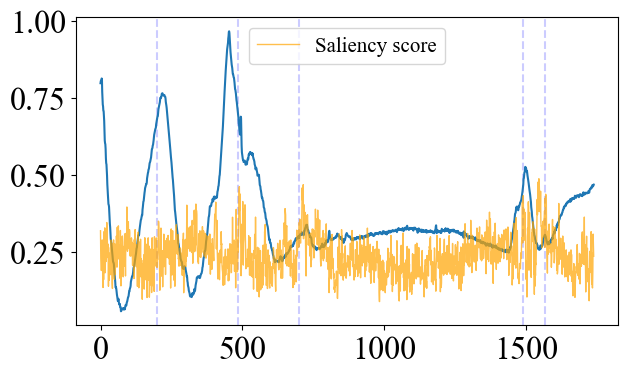

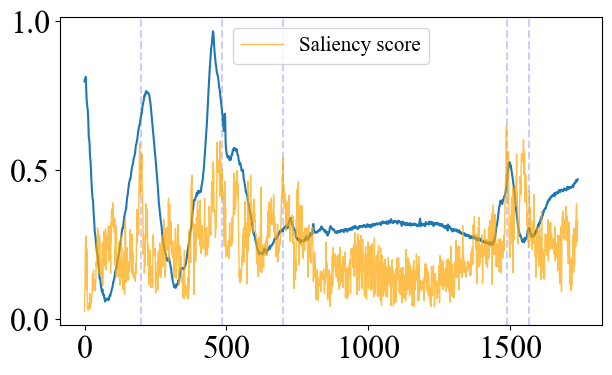

In [5]:
ranges = [[80, 320], [360, 610], [650, 750], [1430, 1550], [1555, 1580]]
r_ix = [np.median(np.arange(r[0], r[1])).astype(int) for r in ranges]
print(r_ix)
plt.rcParams.update({'font.size': 23})
plt.rcParams["font.family"] = "Times New Roman"
if True:
#for d, n in zip(data, data_names):
    d = data[-1]
    n = data_names[-1]
    print(n)
        
    dn = np.copy(d.reshape((-1, 1738)))

    dn = dn[np.sum(dn, axis = 1) != 0.0]

    inp = tf.constant(dn[:100])

    
    with tf.GradientTape() as tape:
        
        tape.watch(inp)
        result = ensemble_model(inp)[-1]

        grads = tape.gradient(tf.gather(result, r_ix, axis = 1), inp)
        print(grads.numpy().shape)
        out = grads.numpy()
        out = np.mean(np.abs(out)/np.max(np.abs(out), axis = 0), axis = 0)
        
        plt.figure(figsize=(7, 4))
        for r in r_ix:
            plt.axvline(r, color = 'b', linestyle = "--", alpha = 0.2)
        plt.plot(np.median(dn, axis = 0))
        plt.plot(np.squeeze(out), alpha = 0.7, linewidth = 1, color = "Orange", label = "Saliency score")
        plt.legend(fontsize = 15)
        plt.savefig("Figures/LiveCellSalMap_ensemble_" + n +".png", transparent = True,
                   bbox_inches='tight', pad_inches=0.75)
        plt.show()


    with tf.GradientTape() as tape:
        
        tape.watch(inp)
        result = standard_model(inp)[-1]

        grads = tape.gradient(tf.gather(result, r_ix, axis = 1), inp)
        out = grads.numpy()
        out = np.mean(np.abs(out)/np.max(np.abs(out), axis = 0), axis = 0)
        
        plt.figure(figsize=(7, 4))
        #plt.plot(dn[0], alpha = 0.2, linestyle = "--", linewidth = 1, color = "Black", label = "Input")
        for r in r_ix:
            plt.axvline(r, color = 'b', linestyle = "--", alpha = 0.2)

        plt.plot(np.median(dn, axis = 0))
        plt.plot(np.squeeze(out), alpha = 0.7, linewidth = 1, color = "Orange", label = "Saliency score")
        
        plt.legend(fontsize = 15)
        plt.savefig("Figures/LiveCellSalMap_standard_" + n +".png", transparent = True,
                   bbox_inches='tight', pad_inches=0.75)
        plt.show()
    

[199, 484, 699, 1489, 1567]
cell100x2sec25slit.h5


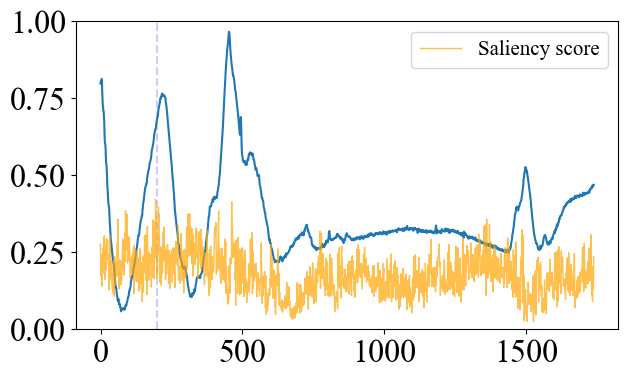

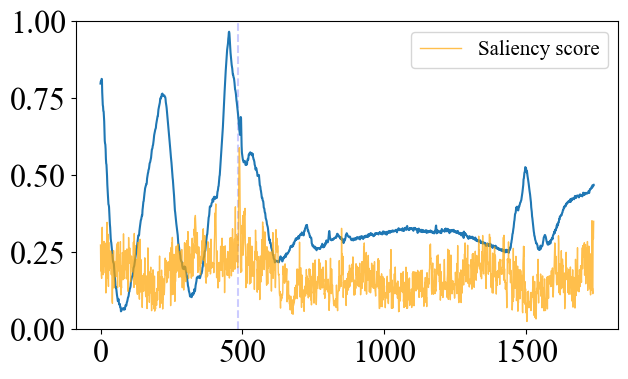

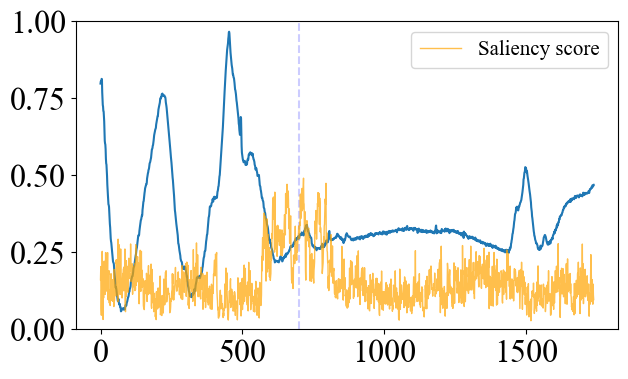

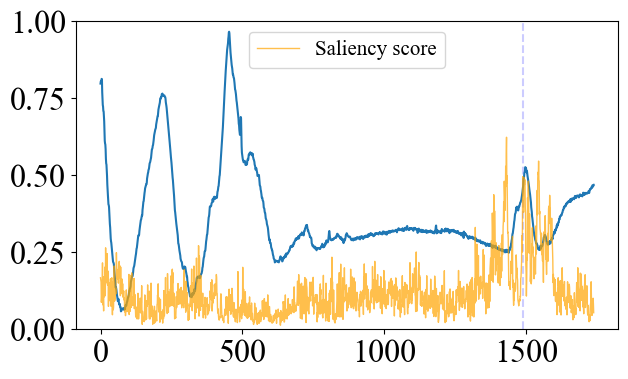

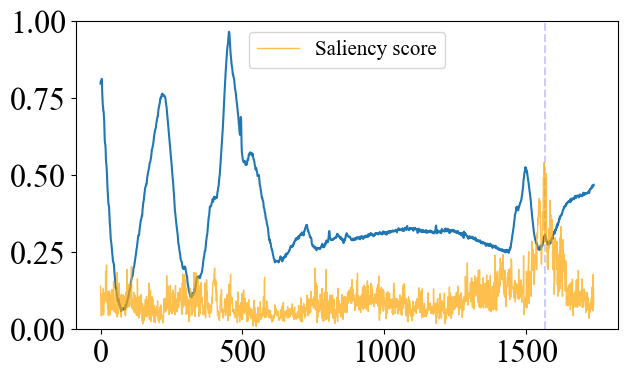

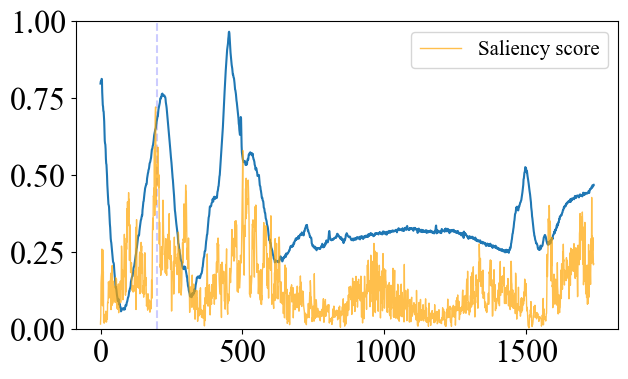

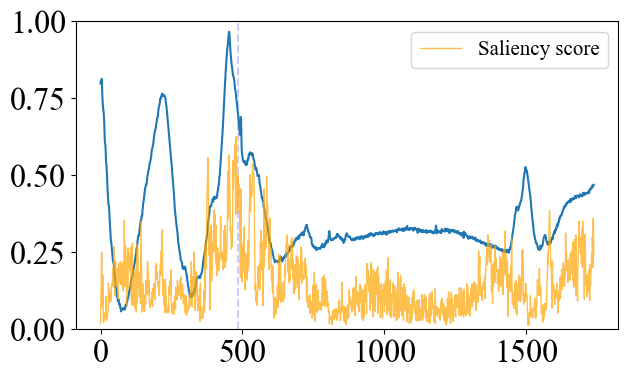

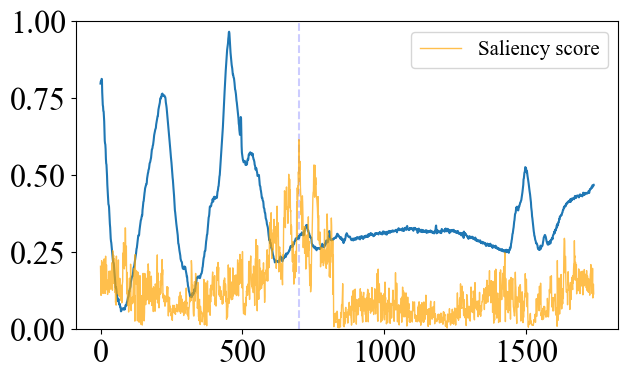

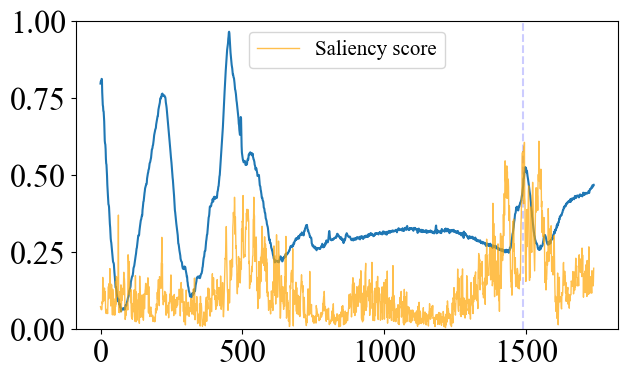

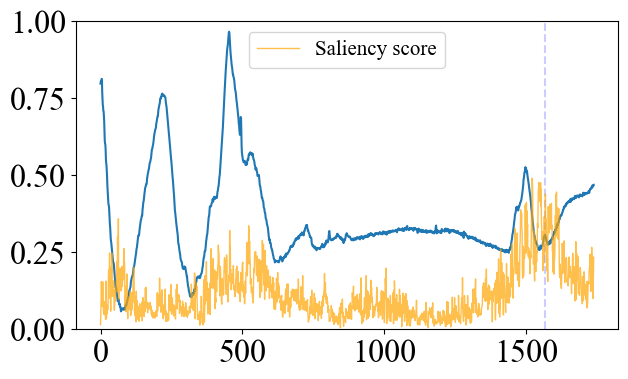

In [4]:
ranges = [[80, 320], [360, 610], [650, 750], [1430, 1550], [1555, 1580]]
r_ix = [np.median(np.arange(r[0], r[1])).astype(int) for r in ranges]
print(r_ix)
plt.rcParams.update({'font.size': 23})
plt.rcParams["font.family"] = "Times New Roman"
if True:
#for d, n in zip(data, data_names):
    d = data[-1]
    n = data_names[-1]
    print(n)
        
    dn = np.copy(d.reshape((-1, 1738)))

    dn = dn[np.sum(dn, axis = 1) != 0.0]

    inp = tf.constant(np.nan_to_num(dn[:100]))

    
    
        
        
        
    for i in r_ix:
        with tf.GradientTape() as tape:
            tape.watch(inp)
            result = ensemble_model(inp)[-1]
            grads = tape.gradient(tf.gather(result, [i], axis = 1), inp)

            out = grads.numpy()
            out = np.median(np.abs(out)/np.max(np.abs(out), axis = 0), axis = 0)
            
            plt.figure(figsize=(7, 4))
            plt.axvline(i, color = 'b', linestyle = "--", alpha = 0.2)
            plt.plot(np.median(dn, axis = 0))
            plt.plot(np.squeeze(out), alpha = 0.7, linewidth = 1, color = "Orange", label = "Saliency score")
            plt.ylim([0, 1])
            plt.legend(fontsize = 15)
            #plt.savefig("Figures/HF2600SalMap_ensemble_" + n +".png", transparent = True,
            #           bbox_inches='tight', pad_inches=0.75)
            plt.show()


    
        
        

    for i in r_ix:
        with tf.GradientTape() as tape:
            tape.watch(inp)
            result = standard_model(inp)[-1]
            grads = tape.gradient(tf.gather(result, [i], axis = 1), inp)

            out = grads.numpy()
            out = np.median(np.abs(out)/np.max(np.abs(out), axis = 0), axis = 0)
            
            plt.figure(figsize=(7, 4))
            plt.axvline(i, color = 'b', linestyle = "--", alpha = 0.2)
            plt.plot(np.median(dn, axis = 0))
            plt.plot(np.squeeze(out), alpha = 0.7, linewidth = 1, color = "Orange", label = "Saliency score")
            plt.ylim([0, 1])
            plt.legend(fontsize = 15)
            #plt.savefig("Figures/HF2600SalMap_ensemble_" + n +".png", transparent = True,
            #           bbox_inches='tight', pad_inches=0.75)
            plt.show()
    
    